<a href="https://colab.research.google.com/github/KateT840/M-computacionales-1/blob/main/Parcial_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install emcee
!pip install corner

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import os
import scipy.optimize as spo
from scipy.stats import poisson, norm
from math import factorial, exp


In [4]:
x1 = np.array([15, 15, 13, 17, 15])
x2 = np.array([18, 20, 16, 21, 15])
_x = (x1, x2)
p0 = [1.5, 0.7, 0.8]

In [5]:
#Estimación de la tasa de muones con dos centelladores.
#Punto 1:
def log_likelihood(p, x):
    lam, eps1, eps2 = p
    if lam <= 0 or eps1 <= 0 or eps2 <= 0:
        return -np.inf
    x1, x2 = x
    t = 10
    mu1 = lam * t * eps1
    mu2 = lam * t * eps2
    return np.sum(poisson.logpmf(x1, mu=mu1)) + np.sum(poisson.logpmf(x2, mu=mu2))

In [6]:
log_likelihood(p0, _x)

np.float64(-34.94264074378715)

In [7]:
#Punto 2:
lambdas = np.linspace(1.0, 2.0, 10)
eps1s = np.linspace(0.4, 1.0, 10)
eps2s = np.linspace(0.4, 1.2, 10)

In [8]:
#Punto 3
def log_prior(p):
    lam, eps1, eps2 = p
    if lam <= 0 or not (0 < eps1 <= 1.0) or not (0 < eps2 <= 1.0):
      return -np.inf
    lp_eps1 = norm.logpdf(eps1, loc=0.7, scale=0.1)
    lp_eps2 = norm.logpdf(eps2, loc=0.8, scale=0.3)
    return lp_eps1 + lp_eps2

In [9]:
log_prior(p0)

np.float64(1.6686808309106362)

In [10]:
def log_posterior(p, x):
    lp = log_prior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(p, x)

In [11]:
log_posterior(p0,_x)

np.float64(-33.273959912876514)

In [14]:
n_walkers, n_params = 50, 3
initial = np.array([1.5, 0.7, 0.8])
pos = initial + 1e-4 * np.random.randn(n_walkers, n_params)
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=(_x,))
pos,prob,state = sampler.run_mcmc(pos,10000,progress=True)

100%|██████████| 10000/10000 [04:53<00:00, 34.09it/s]


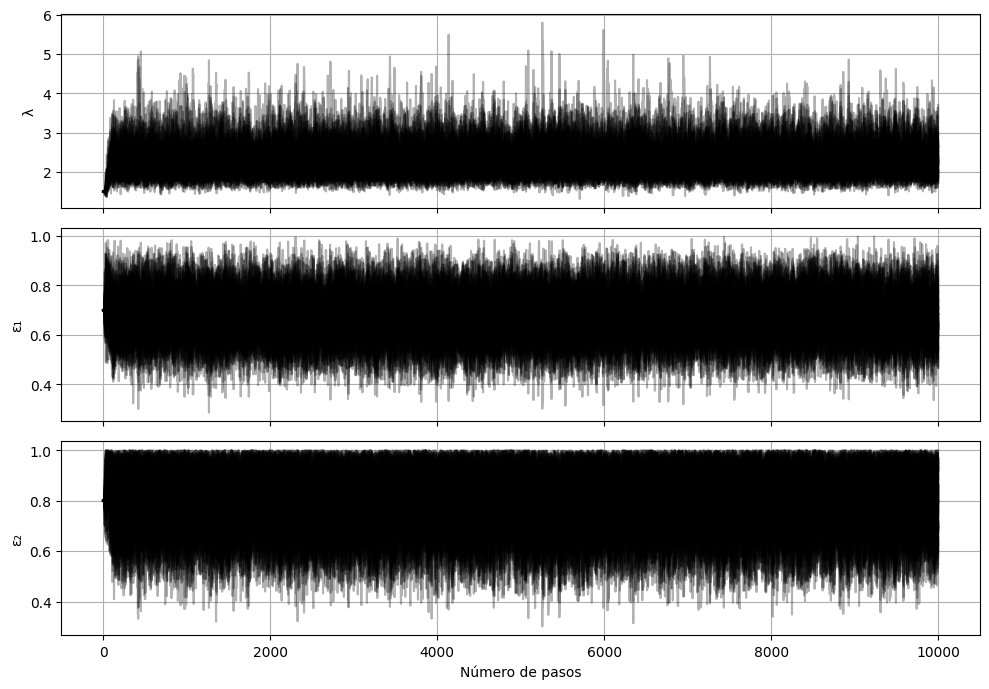

In [15]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels =  ["λ", "ε₁", "ε₂"]
for i in range(3):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_ylabel(labels[i])
    ax.grid()

axes[-1].set_xlabel("Número de pasos")
plt.tight_layout()
plt.show()

In [16]:
#Punto 4
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([2.23790729, 0.67860266, 0.80078193])

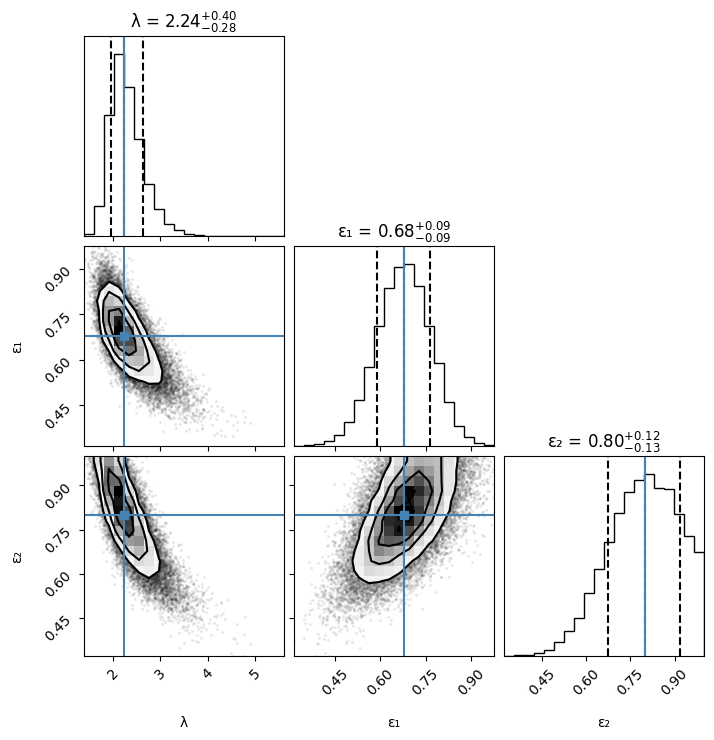

In [17]:
figure = corner.corner(flat_samples, labels=labels, truths=truths, quantiles=[0.16,0.5,0.84], show_titles=True)

In [18]:
#Punto 5
mu = 2.24 * 10 * 0.68  # μ1
prob = 0
for k in range(6):
    prob += exp(-mu) * mu**k / factorial(k)

print(f"P(X1 ≤ 5) = {prob:.5f}")

P(X1 ≤ 5) = 0.00238
